## Import Libraries

In [1]:
import pandas as pd
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

pd.set_option('display.max_columns', 100)
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## Load Data

In [2]:
# Load r/Bitcoin and r/Ethereum datasets
df_btc = pd.read_csv('../data/bitcoin_dataset.csv')
df_eth = pd.read_csv('../data/ethereum_dataset.csv')

## 2. Data Cleansing, Pre-Processing, Engineering and Exploratory Data Analysis

The above datasets each containing 3,000 submissions from r/Bitcoin and r/Ehtereum were combined into a single dataset. Columns that are deemed irrelevant to our analysis and classifier were dropped. To minimize noise in the data, we removed submissions with 'selftext' that have actually been removed by Reddit's moderator, spam-filter and user. During pre-processing, we removed punctuation, tokenized, removed stopwords and lemmatized from the text data in 'title' and 'selftext' columns. This helped us highlight attributes that we want our models to pick up on. 

Through data engineering and exploratory data anaylsis, we firstly gathered that the length of 'selftext' is less than three times as long as the length of 'title' on average across all submissions, on average. Note that average length of title across all submissions around 7. Secondly , we found a large number of common words in the titles and posts of the subreddits and some of those common words were also removed. Given that the length of 'selftext' is less than three times as long as the length of 'title', on average, we believe that forming new column to combine 'selftext_clean' and 'title_clean' would work better as text features. Finally, the breakdown of 'post_hint' can explain the absence of 'selftext' in majority (>52.0%) of the submissions. These posts are expressed in the form of a link, image or video. It seemed like humans have a preference to express ideas on Bitcoin and Ethereum through the use of richer media rather than plain text.

### 2.1 Data Cleansing

In this section, we will combine the dataset of the two subreddit follow by performing the following steps:
1. Identify and select columns that are useful/relevant for our classifier,
2. Deal with missing values by means of simple imputation and,
3. Minimize noise by removing rows containing certain values in the 'removed_by_category'.

In [3]:
pd.set_option('display.max_columns', 100)
# Display the shape follow by first 5 rows of the r/Bitcoin dataset
print(df_btc.shape)
df_btc.head()

(3000, 82)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,removed_by_category,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,post_hint,preview,thumbnail_height,thumbnail_width,url_overridden_by_dest,media,media_embed,secure_media,secure_media_embed,distinguished,suggested_sort,link_flair_text,gallery_data,is_gallery,media_metadata,author_flair_background_color,banned_by,author_cakeday,crosspost_parent,crosspost_parent_list
0,[],False,theremnanthodl,noob,"[{'e': 'text', 't': 'redditor for a day'}]",2ec8e69e-6c36-11e9-a04b-0afb553d4ea6,redditor for a day,dark,richtext,t2_dg8srid3,False,False,False,[],False,False,1626939006,self.Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op915k/bitcoin_town_a_fiction_novel_about_using_bitcoin/,{},op915k,False,False,False,False,False,False,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/Bitcoin/comments/op915k/bitcoin_town_a_fiction_novel_about_using_bitcoin/,False,6,reddit,1626939018,1,[removed],True,False,False,Bitcoin,t5_2s3qj,3206851,public,self,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,0,[],1.0,https://www.reddit.com/r/Bitcoin/comments/op915k/bitcoin_town_a_fiction_novel_about_using_bitcoin/,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,theremnanthodl,NaN,[],NaN,NaN,NaN,text,t2_dg8srid3,False,False,False,[],False,False,1626938084,self.Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8uoi/bitcoin_town_a_fiction_novel_about_using_bitcoin/,{},op8uoi,False,False,False,False,False,False,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/Bitcoin/comments/op8uoi/bitcoin_town_a_fiction_novel_about_using_bitcoin/,False,6,moderator,1626938095,1,[removed],True,False,False,Bitcoin,t5_2s3qj,3206830,public,self,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,0,[],1.0,https://www.reddit.com/r/Bitcoin/comments/op8uoi/bitcoin_town_a_fiction_novel_about_using_bitcoin/,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,ReadDailyCoin,noob,"[{'e': 'text', 't': 'redditor for 3 months'}]",2ec8e69e-6c36-11e9-a04b-0afb553d4ea6,redditor for 3 months,dark,richtext,t2_bmm97n7n,False,False,False,[],False,False,1626937970,dailycoin.com,https://www.reddit.com/r/Bitcoin/comments/op8tvn/crypto_influencers_dorsey_woods_and_musk_faceoff/,{},op8tvn,False,True,False,False,False,True,False,False,NaN,[],dark,text,False,False,True,1,0,False,all_ads,/r/Bitcoin/comments/op8tvn/crypto_influencers_dorsey_woods_and_musk_faceoff/,False,6,NaN,1626937981,1,NaN,True,False,False,Bitcoin,t5_2s3qj,3206827,public,https://b.thumbs.redditmedia.com/JRvcyvkzAnY7NmTPnBFJiso0LwaRPVEZJSluXm0opHE.jpg,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",0,[],1.0,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,all_ads,6,link,"{'enabled': False, 'images': [{'id': 'rYyDll03SLRxY1iij5Ydst_cOFjkGdfSF2xRhMIVeoQ', 'resolutions...",73.0,140.0,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,theloiteringlinguist,NaN,[],NaN,NaN,NaN,text

In [4]:
# Display the shape follow by first 5 rows of the r/Bitcoin dataset
print(df_eth.shape)
df_eth.head()

(3000, 80)


,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,contest_mode,created_utc,domain,full_link,gildings,id,is_created_from_ads_ui,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,pwls,retrieved_on,score,selftext,send_replies,spoiler,stickied,subreddit,subreddit_id,subreddit_subscribers,subreddit_type,suggested_sort,thumbnail,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,author_is_blocked,removed_by_category,thumbnail_height,thumbnail_width,media,media_embed,post_hint,preview,secure_media,secure_media_embed,url_overridden_by_dest,crosspost_parent,crosspost_parent_list,author_flair_background_color,author_flair_text_color,banned_by,author_cakeday,is_gallery,gallery_data,media_metadata,poll_data
0,[],False,wuzzgucci,NaN,[],NaN,text,t2_53ftzlxj,False,False,[],False,False,1626938727,self.ethereum,https://www.reddit.com/r/ethereum/comments/op8z9u/should_i_sell_bitcoin_and_just_go_all_in_ether...,{},op8z9u,False,True,False,False,False,True,True,False,NaN,[],dark,text,False,False,False,44,0,False,all_ads,/r/ethereum/comments/op8z9u/should_i_sell_bitcoin_and_just_go_all_in_ethereum/,False,6,1626938737,1,"* I have like $37.5k invested total in bitcoin, and after the crash, I only have $10.8k gains. I...",True,False,False,ethereum,t5_2zf9m,1044237,public,top,self,Should I sell bitcoin and just go all in ethereum?,0,[],1.0,https://www.reddit.com/r/ethereum/comments/op8z9u/should_i_sell_bitcoin_and_just_go_all_in_ether...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,Needle_NFT,NaN,[],NaN,text,t2_bamj1t7z,False,False,[],False,False,1626938319,self.ethereum,https://www.reddit.com/r/ethereum/comments/op8wec/the_hug_ultra_rare_11/,{},op8wec,False,False,False,False,False,False,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/ethereum/comments/op8wec/the_hug_ultra_rare_11/,False,6,1626938329,1,[removed],True,False,False,ethereum,t5_2zf9m,1044231,public,top,https://b.thumbs.redditmedia.com/E3o6DfIA91PAb-pjq9tuZFQMxqzhaIv8G2TZdvniAMo.jpg,The hug – ultra rare 1/1,0,[],1.0,https://www.reddit.com/r/ethereum/comments/op8wec/the_hug_ultra_rare_11/,all_ads,6,False,moderator,140.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,AOFEX__Official,NaN,[],NaN,text,t2_b00ercqa,False,False,[],False,False,1626938005,self.ethereum,https://www.reddit.com/r/ethereum/comments/op8u49/l2beat_website_upgrade/,{},op8u49,False,False,False,False,False,False,True,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/ethereum/comments/op8u49/l2beat_website_upgrade/,False,6,1626938016,1,[removed],True,False,False,ethereum,t5_2zf9m,1044229,public,top,self,L2BEAT website upgrade,0,[],1.0,https://www.reddit.com/r/ethereum/comments/op8u49/l2beat_website_upgrade/,all_ads,6,False,reddit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,FarEnergy3518,NaN,[],NaN,text,t2_bonkrdx5,False,False,[],False,False,1626937513,m.youtube.com,https://www.reddit.com/r/ethereum/comments/op8qkc/the_internet_world_of_our_future_insane_the_best/,{},op8qkc,False,False,False,False,False,False,False,False,NaN,[],dark,text,False,False,True,0,0,False,all_ads,/r/ethereum/comments/op8qkc/the_internet_world_of_our_future_insane_the_best/,False,6,1626937525,1,NaN,True,False,False,ethereum,t5_2zf9m,1044226,public,top,https://b.thumbs.redditmedia.com/ohFTtX4eGkHE1mc-bE5LKeF1B3jRshDA0lBAf-djPjM.jpg,The Internet World of our Future!!! (INSANE) the best vid I’ve ever watched in my life of crypto,0,[],1.0,https://m.youtube.com/watch?v=WgyM0tQ0

Among the many columns in each dataset, we identified a few common columns that would be useful in building our classification models. The columns chosen are:
* 'title' and 'selftext' - They contain text data which provide a brief description and the content of a post respectively. They can potentially serve our classifier well.
* 'post_hint' - It provides a clue to missing values in 'selftext' column. Missing text values in 'selftext' column could imply the post is centred around non-textual data such as an image or video or the post contains a hyperlink.
* 'num_comments' - It may be interesting to find out whether there is any relationship between 'num_comments' and 'title' and/or 'selftext'.
* 'subreddit' - Name of the subreddit will be used later to create a new column that binarize the subreddit a submission originates from. 
* 'removed_by_category' - Indicates whether the 'selftext' has been removed and how, if it has been removed.
* 'url' - Retained for reference, if necessary.

In [5]:
# Display first 5 rows of df_btc data frame
df_btc[['title', 'selftext', 'post_hint','num_comments','removed_by_category','subreddit','url']].head()


,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url
0,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],NaN,0,reddit,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op915k/bitcoin_town_a_fiction_novel_about_using_bitcoin/
1,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],NaN,0,moderator,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8uoi/bitcoin_town_a_fiction_novel_about_using_bitcoin/
2,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",NaN,link,1,NaN,Bitcoin,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/
3,Elon Musk’s View on Bitcoin (July 21 2021),NaN,rich:video,2,NaN,Bitcoin,https://youtu.be/7pLusWKO86Y
4,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin....",NaN,image,20,automod_filtered,Bitcoin,https://i.redd.it/h0e4u1t5opc71.jpg


In [6]:
# Display first 5 rows of df_eth data frame
df_eth[['title', 'selftext', 'post_hint',  'num_comments','removed_by_category','subreddit','url']].head()

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url
0,Should I sell bitcoin and just go all in ethereum?,"* I have like $37.5k invested total in bitcoin, and after the crash, I only have $10.8k gains. I...",NaN,44,NaN,ethereum,https://www.reddit.com/r/ethereum/comments/op8z9u/should_i_sell_bitcoin_and_just_go_all_in_ether...
1,The hug – ultra rare 1/1,[removed],NaN,0,moderator,ethereum,https://www.reddit.com/r/ethereum/comments/op8wec/the_hug_ultra_rare_11/
2,L2BEAT website upgrade,[removed],NaN,0,reddit,ethereum,https://www.reddit.com/r/ethereum/comments/op8u49/l2beat_website_upgrade/
3,The Internet World of our Future!!! (INSANE) the best vid I’ve ever watched in my life of crypto,NaN,rich:video,0,moderator,ethereum,https://m.youtube.com/watch?v=WgyM0tQ0Hfs
4,I like the way Polygon thinks - Mihailo Bjelic on Twitter,NaN,link,2,NaN,ethereum,https://twitter.com/mihailobjelic/status/1417591789645561856?s=21


In [7]:
# Create new data frames with identified 7 columns
bitcoin_columns = df_btc[['title', 'selftext', 'post_hint',  'num_comments','removed_by_category', 'subreddit','url']]
ethereum_columns = df_eth[['title', 'selftext', 'post_hint',  'num_comments','removed_by_category', 'subreddit','url']]

In [8]:
# Concatenate both data frames
combined_data = pd.concat([bitcoin_columns,ethereum_columns],axis=0, ignore_index=True)  

In [9]:
# S
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                6000 non-null   object
 1   selftext             3104 non-null   object
 2   post_hint            3007 non-null   object
 3   num_comments         6000 non-null   int64 
 4   removed_by_category  3214 non-null   object
 5   subreddit            6000 non-null   object
 6   url                  6000 non-null   object
dtypes: int64(1), object(6)
memory usage: 328.2+ KB


In [10]:
# Create a new column to classify post that falls under r/Bitcoin as '1' and post that falls under r/Ethereum as '0' 
combined_data['is_bitcoin'] = combined_data['subreddit'].map({'Bitcoin': 1, 'ethereum': 0})

In [11]:
# Display first 5 rows of combined_data to verify creation of 'is_bitcoin' column
combined_data.head()

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url,is_bitcoin
0,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],NaN,0,reddit,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op915k/bitcoin_town_a_fiction_novel_about_using_bitcoin/,1
1,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],NaN,0,moderator,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8uoi/bitcoin_town_a_fiction_novel_about_using_bitcoin/,1
2,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",NaN,link,1,NaN,Bitcoin,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,1
3,Elon Musk’s View on Bitcoin (July 21 2021),NaN,rich:video,2,NaN,Bitcoin,https://youtu.be/7pLusWKO86Y,1
4,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin....",NaN,image,20,automod_filtered,Bitcoin,https://i.redd.it/h0e4u1t5opc71.jpg,1


In [12]:
# Check for missing values in combined_data data frame
combined_data.isnull().sum()

title                     0
selftext               2896
post_hint              2993
num_comments              0
removed_by_category    2786
subreddit                 0
url                       0
is_bitcoin                0
dtype: int64

In [13]:
# Fill missing values in 'post_hint' with 'None'
combined_data.fillna(combined_data[['post_hint']].fillna('None'),inplace=True)

In [14]:
# Check for missing values in combined_data data frame
combined_data.isnull().sum()

title                     0
selftext               2896
post_hint                 0
num_comments              0
removed_by_category    2786
subreddit                 0
url                       0
is_bitcoin                0
dtype: int64

In [15]:
# Check the distribution of missing values in 'selftext' column in the subreddits
combined_data[combined_data['selftext'].isnull()][['title']].groupby(combined_data['subreddit']).count()

,title
subreddit,
Bitcoin,1517
ethereum,1379


Around half of the posts in each of the subreddits have missing values in 'selftext', we do not want to remove these posts as their title is still useful to build our classifier.

In [16]:
# Fill missing values in 'selftext' column with 'emptypost'
combined_data.fillna(combined_data[['selftext']].fillna('emptypost'),inplace=True)

In [17]:
# Check for missing values in combined_data data frame
combined_data.isnull().sum()

title                     0
selftext                  0
post_hint                 0
num_comments              0
removed_by_category    2786
subreddit                 0
url                       0
is_bitcoin                0
dtype: int64

In [18]:
# Fill missing values in 'removed_by_category' column with 'None' to indicate that actual empty post
combined_data.fillna(combined_data[['removed_by_category']].fillna('None'),inplace=True)

In [19]:
combined_data['removed_by_category'].value_counts()

None                2786
reddit              1522
moderator           1197
automod_filtered     469
deleted               25
author                 1
Name: removed_by_category, dtype: int64

We observed there are many submissions which contained '[removed]' and '[deleted]' in the 'selftext' column. According to Reddit, they likely mean the post was removed by a mod or an automoderator, or a spam filter because the post/user has violated the terms of Reddit. It is not definitive as a user could simply enter the text [removed] in the selftext to make it appear it was removed. To minimize noise in the dataset, we refer to the 'removed_by_category' column to filter off submissions that were actually removed or deleted. 

In [20]:
combined_data[combined_data['removed_by_category'] == 'reddit'][['title','selftext','removed_by_category']].head()

,title,selftext,removed_by_category
0,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],reddit
12,Air Drop 2 | Free Crypto earning |,emptypost,reddit
17,Create your Token in 3 easy steps with SuperToken,[removed],reddit
21,Senator Rand Paul CALLS OUT Fauci for COVID Coverup,emptypost,reddit
22,Technology .. please subscribe to our channel for supporting poverty,emptypost,reddit


In [21]:
combined_data[combined_data['removed_by_category'] == 'moderator'][['title','selftext','removed_by_category']].head()

,title,selftext,removed_by_category
1,Bitcoin Town - A fiction novel about using Bitcoin against the Great Reset,[removed],moderator
9,"Only morons post about Elon Musk, SpaceX, or Tesla",[removed],moderator
16,Will eth2 affect bitcoin/bitcoin mining?,[removed],moderator
25,Anyone else dabbling in the micro Bitcoin futures?,[removed],moderator
29,Crypto in the UAE!,emptypost,moderator


In [22]:
combined_data[combined_data['removed_by_category'] == 'automod_filtered'][['title','selftext','removed_by_category']].head()

,title,selftext,removed_by_category
4,"You’ve undoubtedly heard about crypto currencies by now such as Bitcoin, Ethereum and DOGE coin....",emptypost,automod_filtered
7,This is the newest project of him?,emptypost,automod_filtered
8,Is it advisable to use P2P when buying bitcoin ?,emptypost,automod_filtered
27,"Anyone Else? With the U and I so close on the tiny keyboard. Also, why isn't there a butcoin? be...",emptypost,automod_filtered
38,Elon's t-shirt today inspired me to buy one,emptypost,automod_filtered


In [23]:
combined_data[combined_data['removed_by_category'] == 'deleted'][['title','selftext','removed_by_category']].head()

,title,selftext,removed_by_category
366,We have the start of the new bull run cause the classic “Ghost-Giving-The-Finger-Holding-A-Cucum...,emptypost,deleted
1303,ssjjf,emptypost,deleted
1499,US city plans to accept Bitcoin for tax payments. The young mayor wants to enable Jackson reside...,[deleted],deleted
1772,Buy and hold for 20 years - Bitcoin or XRP - why?,emptypost,deleted
2189,Robert Kiyosaki: This is When To Buy Bitcoin,[deleted],deleted


In [24]:
combined_data[combined_data['removed_by_category'] == 'author'][['title','selftext','removed_by_category']].head()

,title,selftext,removed_by_category
3024,Ashton Kutcher &amp; Mila Kunis on Crypto -- WAIT FOR IT!,emptypost,author


In [25]:
# Filter rows with 'reddit', 'moderator', 'automod_filtered', 'deleted' or 'author' in 'removed_by_category' column
combined_data = combined_data[combined_data['removed_by_category'] == 'None']

In [26]:
combined_data.shape

(2786, 8)

In [27]:
combined_data['is_bitcoin'].value_counts()

1    1811
0     975
Name: is_bitcoin, dtype: int64

In [28]:
# Reset index
combined_data.reset_index(drop= True, inplace= True)

In [29]:
combined_data.head()

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url,is_bitcoin
0,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",emptypost,link,1,None,Bitcoin,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,1
1,Elon Musk’s View on Bitcoin (July 21 2021),emptypost,rich:video,2,None,Bitcoin,https://youtu.be/7pLusWKO86Y,1
2,best crypto video ive ever watched,emptypost,rich:video,2,None,Bitcoin,https://www.youtube.com/watch?v=WgyM0tQ0Hfs&amp;t=30s,1
3,what moves crypto market apart from the speculators,I would like to know if there is anything that moves crypto market apart from the speculator...,None,7,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8j7o/what_moves_crypto_market_apart_from_the/,1
4,Help starting crypto business,Hi guys.\n\nI'm interested in starting a crypto business / app www.hashtaghodl.com that would ta...,None,5,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8cdl/help_starting_crypto_business/,1


### 2.2 Pre-Processing

In this section, the following steps will be taken to clean up text data in 'title' and 'selftext' columns.

1. Remove punctuations
2. Tokenization
3. Remove stopwords
4. Lemmatize

Pre-processing is essential to highlight attributes that we want our models to pick up on. 

#### 2.2.1 Create a function to remove punctuation, tokenize, remove stopwords, and lemmatize

In [30]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    # \W matches any non-word character (equivalent to [^a-zA-Z0-9_]). This does not include spaces i.e. \s
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    
    # apply stemming and stopwords exclusion within the same step
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

In [31]:
# Calling clean_text function on 'title' and 'selftext' columns
combined_data['title_clean'] = combined_data['title'].apply(lambda x: clean_text(x))
combined_data['selftext_clean'] = combined_data['selftext'].apply(lambda x: clean_text(x))

In [32]:
# Verify that new columns have been added in data frame
combined_data.columns

Index(['title', 'selftext', 'post_hint', 'num_comments', 'removed_by_category',
       'subreddit', 'url', 'is_bitcoin', 'title_clean', 'selftext_clean'],
      dtype='object')

In [33]:
# Comparing 'title' and 'title_clean' columns
combined_data[['title','title_clean']]

,title,title_clean
0,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference","[crypto, influencers, dorsey, wood, musk, faceoff, bword, conference]"
1,Elon Musk’s View on Bitcoin (July 21 2021),"[elon, musk, view, bitcoin, july, 21, 2021]"
2,best crypto video ive ever watched,"[best, crypto, video, ive, ever, watched]"
3,what moves crypto market apart from the speculators,"[move, crypto, market, apart, speculator]"
4,Help starting crypto business,"[help, starting, crypto, business]"
...,...,...
2781,Best location to store ETH?,"[best, location, store, eth]"
2782,"Bitcoin, Ethereum Drops-Down Its Worth after Options Expire","[bitcoin, ethereum, dropsdown, worth, option, expire]"
2783,Toxic Period,"[toxic, period]"
2784,Buy the dip and then buy craft beer in Ontario with BTC and ETH,"[buy, dip, buy, craft, beer, ontario, btc, eth]"


In [34]:
# Comparing 'selftext' and 'selftext_clean' columns
combined_data[['selftext','selftext_clean']]

,selftext,selftext_clean
0,emptypost,[emptypost]
1,emptypost,[emptypost]
2,emptypost,[emptypost]
3,I would like to know if there is anything that moves crypto market apart from the speculator...,"[, would, like, know, anything, move, crypto, market, apart, speculator, cryptocurrencies, price..."
4,Hi guys.\n\nI'm interested in starting a crypto business / app www.hashtaghodl.com that would ta...,"[hi, guy, im, interested, starting, crypto, business, app, wwwhashtaghodlcom, would, take, small..."
...,...,...
2781,"I know of BlockFi, but looking for more/other recommendations as well please - or if you have fe...","[know, blockfi, looking, moreother, recommendation, well, please, feedback, using, blockfi, curr..."
2782,emptypost,[emptypost]
2783,I understand with ETH being so low that a lot of people may have lost a lot of money recently in...,"[understand, eth, low, lot, people, may, lost, lot, money, recently, eth, oh, god, community, to..."
2784,"Curated selection of craft beer, shipping across Ontario. Pay with BTC, ETH and LTC at checkout....","[curated, selection, craft, beer, shipping, across, ontario, pay, btc, eth, ltc, checkout, must,..."


In [35]:
# Ensure pre-processing did not result in null values
combined_data.isnull().sum()

title                  0
selftext               0
post_hint              0
num_comments           0
removed_by_category    0
subreddit              0
url                    0
is_bitcoin             0
title_clean            0
selftext_clean         0
dtype: int64

### 2.3 Exploratory Data Analysis and Feature Engineering

In [36]:
# Create a column to count the length of 'title_clean' of each post
combined_data['title_length'] = combined_data['title_clean'].apply(lambda x: len(x))

In [37]:
# Create a column to count the length of 'selftext_clean' of each post
combined_data['selftext_length'] = combined_data['selftext_clean'].apply(lambda x: len(x))

In [38]:
# Summary statistics of numeric variables of combined_data data frame
combined_data.describe()

,num_comments,is_bitcoin,title_length,selftext_length
count,2786.000000,2786.000000,2786.000000,2786.000000
mean,22.959799,0.650036,7.545944,19.540560
std,82.408527,0.477044,5.244904,59.565681
min,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,4.000000,1.000000
50%,4.000000,1.000000,6.000000,1.000000
75%,14.000000,1.000000,9.000000,16.000000
max,1561.000000,1.000000,34.000000,1654.000000


The above summary statistics reinforced that 'title_length' and 'selftext_length' of both r/Bitcoin and r/Ethereum subreddits generally contained few texts. On average, the 'selftext_length' of these submissions is less than three times as long as their 'title_length'. However, the high standard deviations and large maximum value in 'title_length' and 'selftext_length' suggests that there are some outliers in the posts collected. Despite verifying that there is no missing value after pre-processing, the minimum value of 'title_length' is zero.

In [39]:
# Lets look at the rows with a 'title_length' of zero
combined_data[combined_data['title_length'] == 0]

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url,is_bitcoin,title_clean,selftext_clean,title_length,selftext_length
601,You have??,Guys I have this in my bag:\n\n\*Bitcoin\n\n\*Ethereum\n\n\*Defit\n\nWhat's yours?\n\nhttps://p...,None,18,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/oni34a/you_have/,1,[],"[, guy, bag, bitcoin, ethereum, defit, whats, httpspreviewredditr6k8pw3d97c71jpgwidth1000ampform...",0,8
1647,What if,What is the same man who created bitcoin also created Covid in order to fuck up the market and s...,None,11,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/ojqi66/what_if/,1,[],"[man, created, bitcoin, also, created, covid, order, fuck, market, screw, centralized, bank, any...",0,14


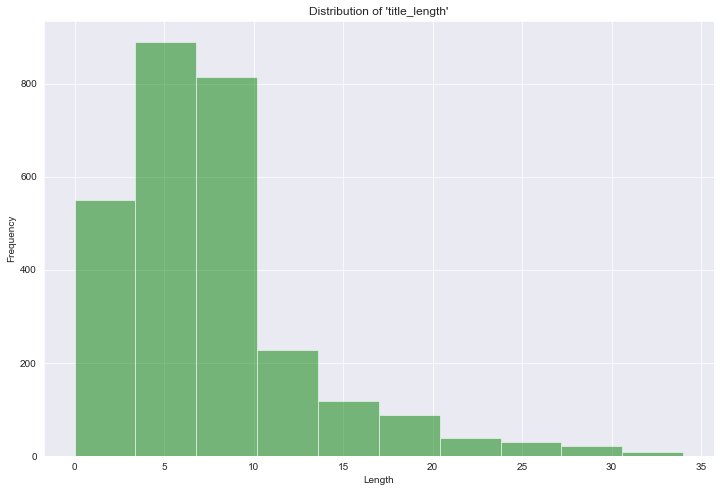

In [40]:
# Plot histogram to show distribution of 'title_length'
plt.figure(figsize=[12,8])
plt.hist(combined_data['title_length'], bins = 10,color='g', alpha = 0.5, label = 'title')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Distribution of 'title_length'");

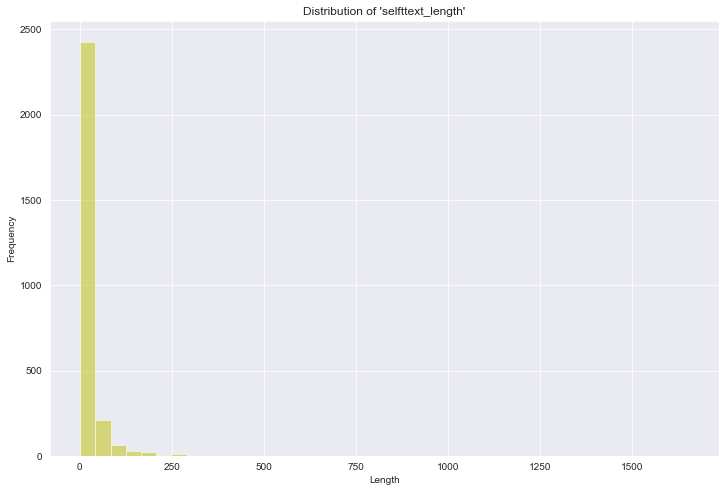

In [41]:
# Plot histogram to show distribution of 'selftext_length'
plt.figure(figsize=[12,8])
plt.hist(combined_data['selftext_length'], bins = 40, color='y', alpha = 0.5, label = 'title')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Distribution of 'selfttext_length'");

From the histograms above, we can see that both distributions are highly skewed to the right. This reaffirmed that 'title_length' and 'selftext_length' contained many outliers. We will not remove these outliers as they contained more text which may be helpful in our classifer.

In [42]:
combined_data.shape

(2786, 12)

In [43]:
# Breakdown of 'post_hint'
combined_data[['title']].groupby(combined_data['post_hint']).count().sort_values(['title'], ascending=False)

,title
post_hint,
None,1149
link,899
rich:video,285
image,206
self,178
hosted:video,69


The breakdown of 'post_hint' can explain the absence of 'selftext' in majority (>52.0%) of the submissions. These posts are expressed in the form of a link, image or video. It seemed like humans find it easier to express ideas on Bitcoin and Ethereum through the use of richer media rather than plain text. The following confirmed that 'emptypost' is expected in 'selftext' column when post_hint is either a link, an image or a video.

In [44]:
combined_data[combined_data['post_hint'] == 'None'][['selftext','post_hint']].head()

,selftext,post_hint
3,I would like to know if there is anything that moves crypto market apart from the speculator...,None
4,Hi guys.\n\nI'm interested in starting a crypto business / app www.hashtaghodl.com that would ta...,None
5,"I might just being stupid, but watching the conference there's the moment Elon asks Dorsey about...",None
8,I was thinking of buying a mining rig with my friend and he said that ethereum 2.0 will affect b...,None
17,"[This is what Musk said, this capricious villain, he is the real biggest dealer.](https://www.re...",None


In [45]:
combined_data[combined_data['post_hint'] == 'hosted:video'][['selftext','post_hint']].head()

,selftext,post_hint
18,emptypost,hosted:video
19,emptypost,hosted:video
93,emptypost,hosted:video
112,emptypost,hosted:video
165,emptypost,hosted:video


In [46]:
combined_data[combined_data['post_hint'] == 'image'][['selftext','post_hint']].head()

,selftext,post_hint
302,emptypost,image
385,emptypost,image
392,emptypost,image
486,emptypost,image
543,emptypost,image


In [47]:
combined_data[combined_data['post_hint'] == 'link'][['selftext','post_hint']].head()

,selftext,post_hint
0,emptypost,link
12,emptypost,link
13,emptypost,link
14,emptypost,link
15,emptypost,link


In [48]:
combined_data[combined_data['post_hint'] == 'rich:video'][['selftext','post_hint']].head()

,selftext,post_hint
1,emptypost,rich:video
2,emptypost,rich:video
7,emptypost,rich:video
37,emptypost,rich:video
70,emptypost,rich:video


In [49]:
combined_data[combined_data['post_hint'] == 'self'][['selftext','post_hint']].head()

,selftext,post_hint
6,The lightning network is a second-layer solution on top of the Bitcoin blockchain that enables q...,self
9,\n\nAs a beginner switching over decentralized finance can be exaggerated but Research is the ...,self
10,\n\nAs a beginner switching over decentralized finance can be exaggerated but Research is the ...,self
11,Please utilize this sticky thread for all general **Bitcoin** discussions! If you see posts on t...,self
46,So basically my idea will combine things I watched in 2 separate videos. \n\nYou may want to wat...,self


While majority of the posts contained data beyond plain text that calls for encryption or transcription before meaningful analysis can be derived, encryption or transcription of non text data goes beyond the scope of this project and will not be performed. Nonetheless, this strengthens our position on combining the 'title_clean' and 'selftext_clean' columns to increase the word count of each post. By doing so, the classification can be done more rigourously in the next section.

#### 2.3.2 Top words in titles and selftext of each subreddit

In [50]:
# Create a filter to remove 'emptypost' from 'selftext_clean' column of r/Bitcoin
btc_filter = (combined_data['is_bitcoin'] == 1) & (combined_data['selftext'] != 'emptypost')
bitcoin_less_emptypost = combined_data[btc_filter]['selftext_clean']

In [51]:
# Create a filter to remove 'emptypost' from 'selftext_clean' column of r/Ethereum
ethereum_filter = (combined_data['is_bitcoin'] == 0) & (combined_data['selftext'] != 'emptypost')
ethereum_less_emptypost = combined_data[ethereum_filter]['selftext_clean']

In [52]:
# Using masks to create slices of our data frame for visualisation and convert 
bitcoin_titles = combined_data[combined_data['is_bitcoin'] ==1]['title_clean'].apply(
                lambda x: ', '.join([str(i) for i in x])
)
bitcoin_posts = bitcoin_less_emptypost.apply(lambda x: ', '.join([str(i) for i in x]))

ethereum_titles = combined_data[combined_data['is_bitcoin'] ==0]['title_clean'].apply(
                lambda x: ', '.join([str(i) for i in x])
)
ethereum_posts = ethereum_less_emptypost.apply(lambda x: ', '.join([str(i) for i in x]))

In [53]:
# Define a function to plot horizontal bar graphs of top 20 words of data_series
def plot_top_20_words(data_series, title, palette):
    # Instantiate CountVecotorizer with stop words, fit and transform data_series
    cvec = CountVectorizer(stop_words='english')
    X = cvec.fit_transform(data_series)
    # Create a data frame of extracted words
    words_df = pd.DataFrame(X.todense(),
                              columns=cvec.get_feature_names())
    total_words = words_df.sum(axis=0)
    
    # Create a final data frame of the top 20 words
    top_20_words = total_words.sort_values(ascending = False).head(20)
    top_20_words_df = pd.DataFrame(top_20_words, columns = ["count"])
    # Plotting frequency of the top 20 words
    sns.set_style("white")
    plt.figure(figsize = (15, 8), dpi=300)
    ax = sns.barplot(y= top_20_words_df.index, x='count', data=top_20_words_df, palette = palette)
    
    plt.xlabel('Count', fontsize=9)
    plt.ylabel('Common words', fontsize=9)
    plt.title(title, fontsize=12)

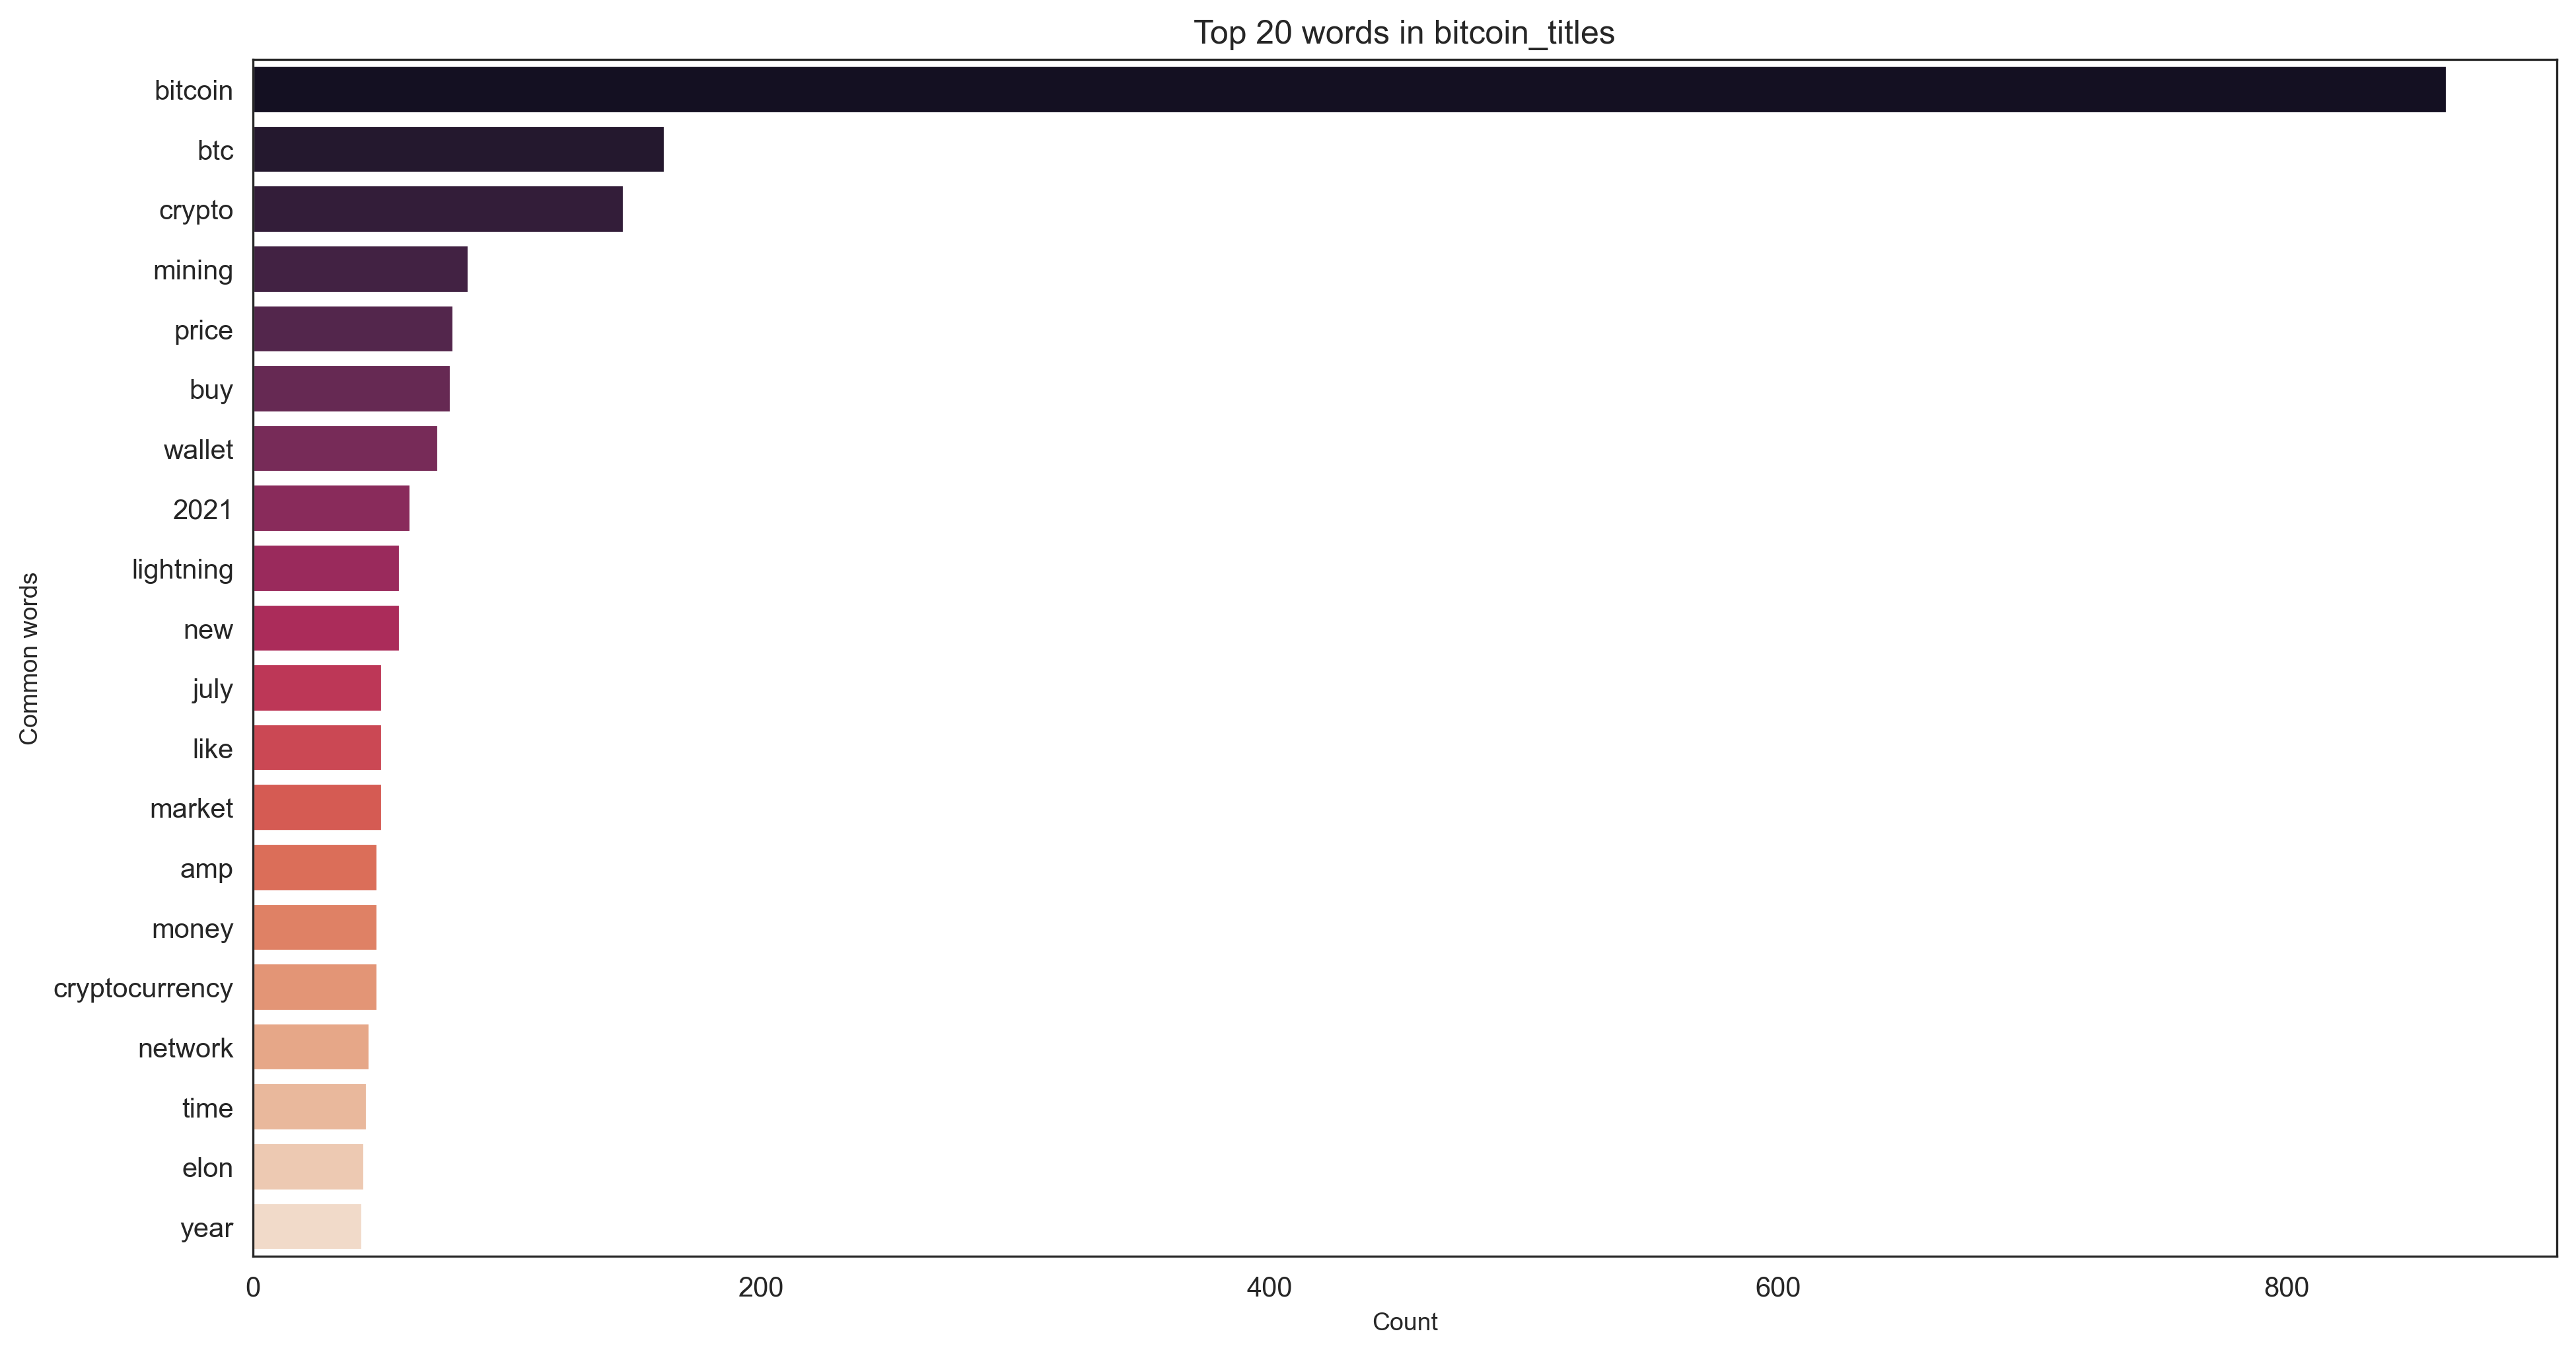

In [54]:
# Call function to plot top 20 words of bitcoin_titles
plot_top_20_words(bitcoin_titles, title = 'Top 20 words in bitcoin_titles', palette = 'rocket')

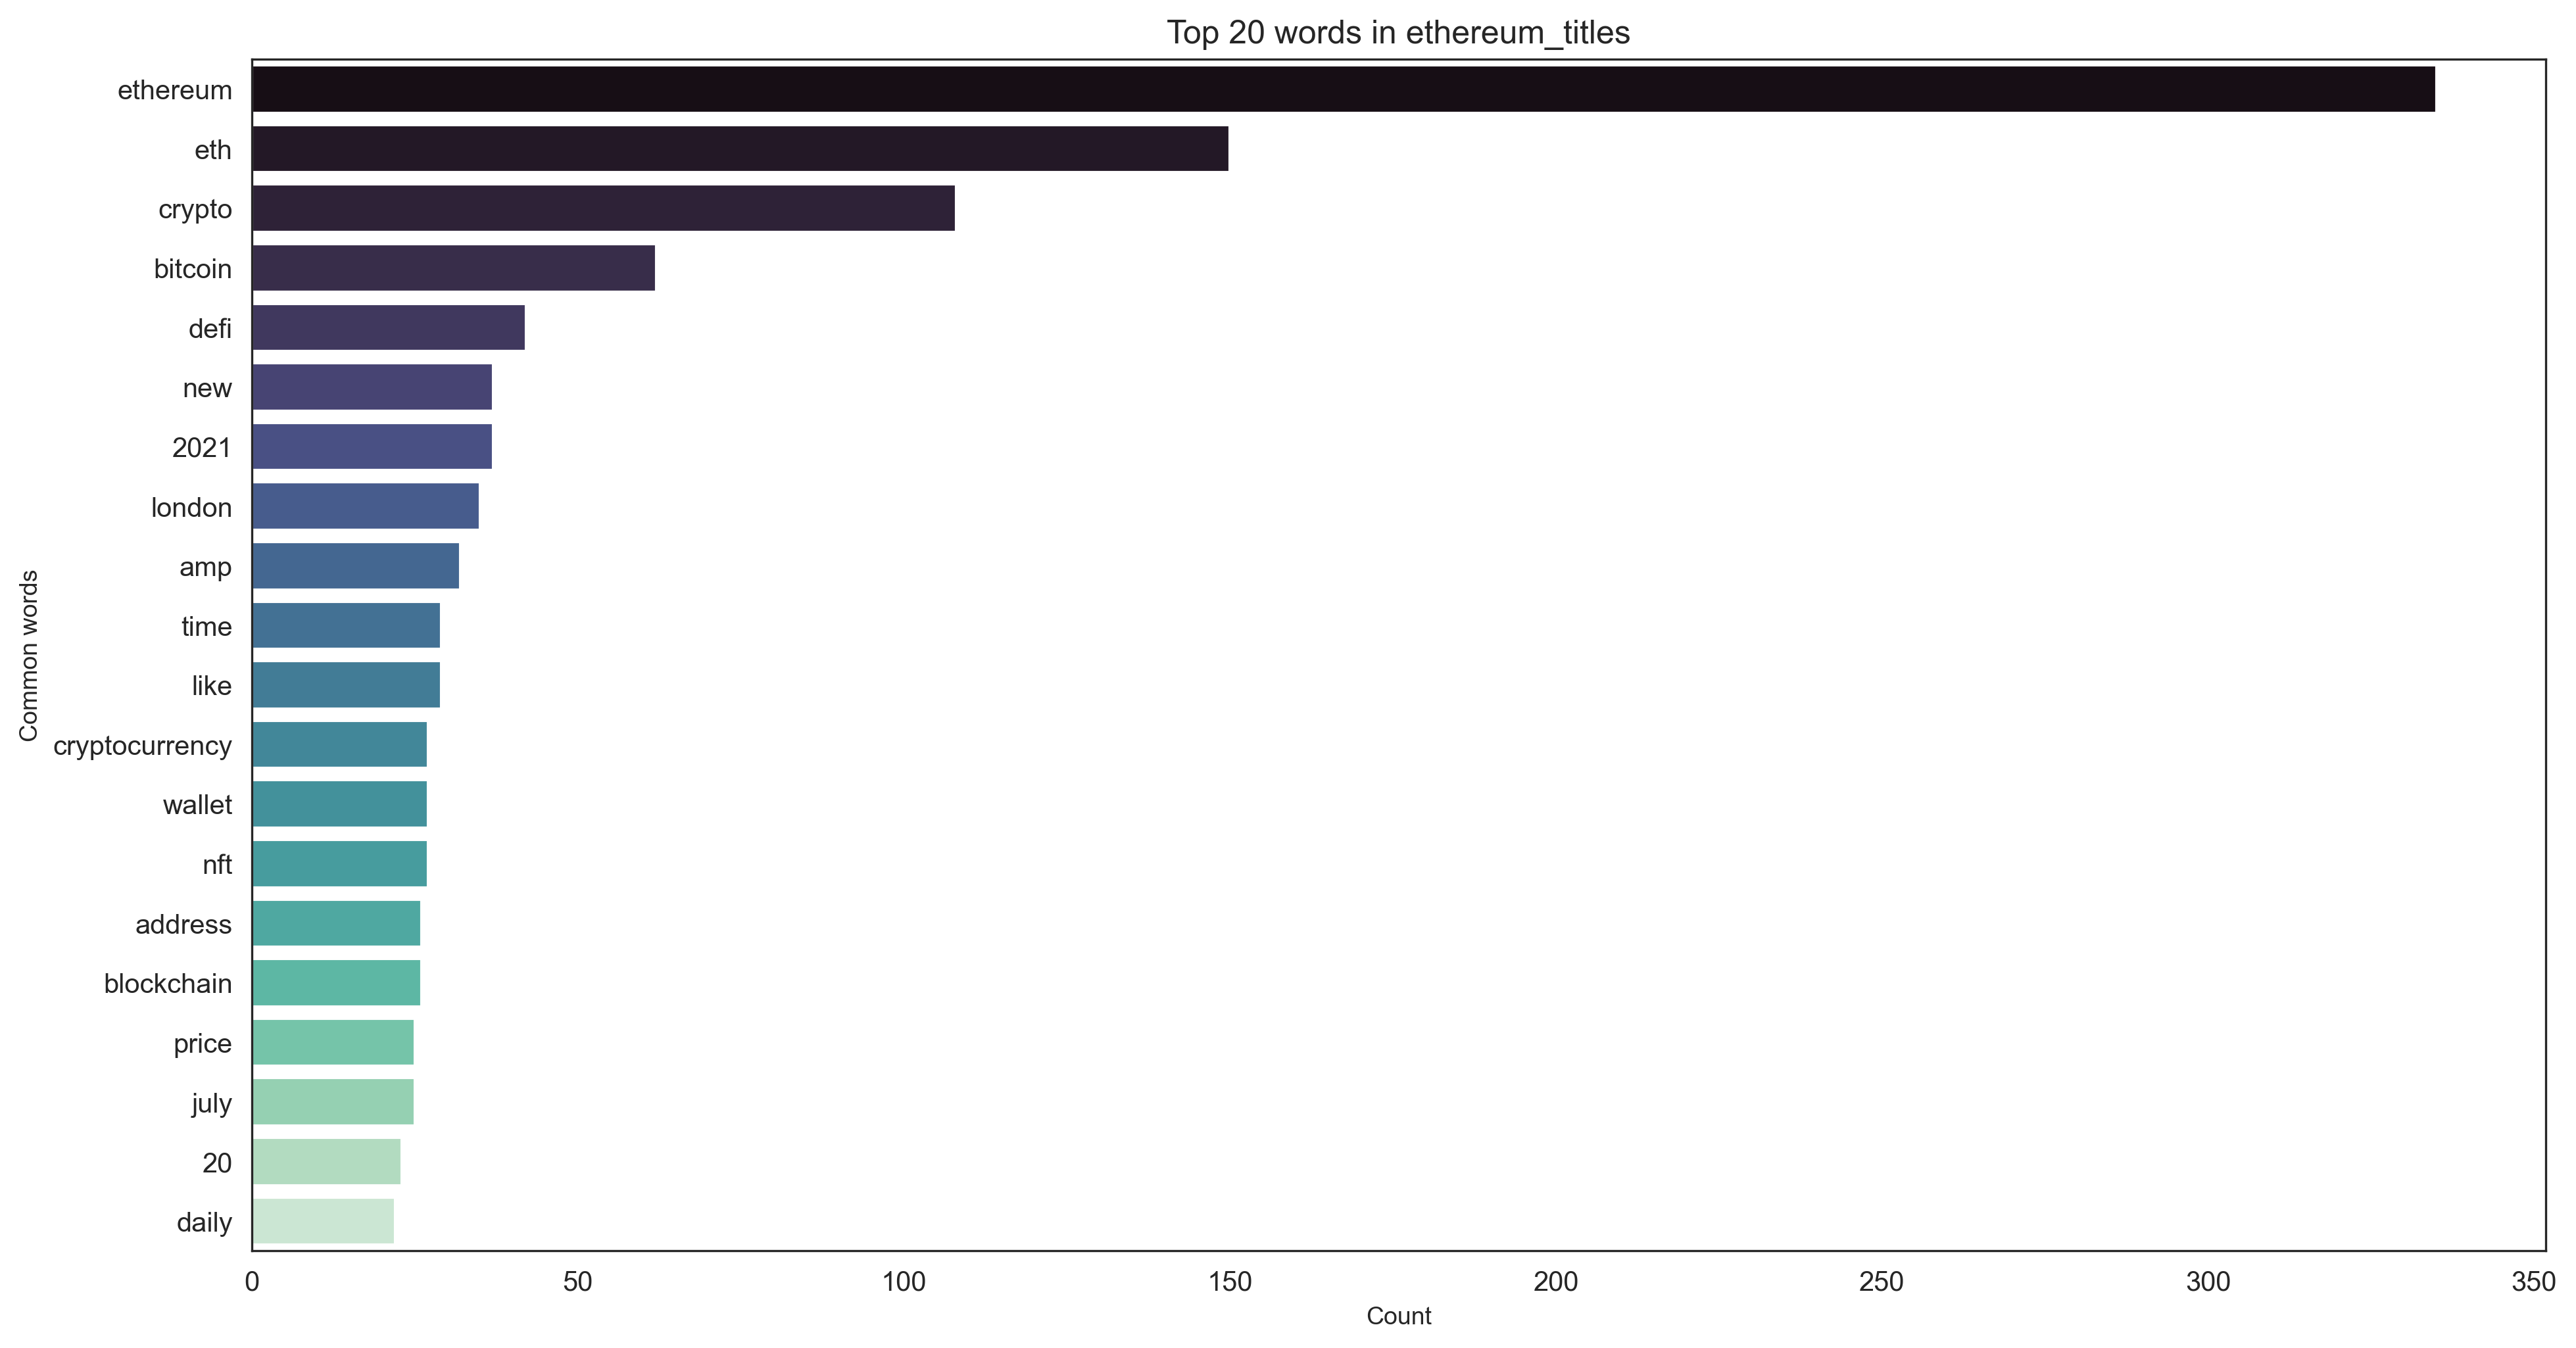

In [55]:
# Call function to plot top 20 words of ethereum_titles
plot_top_20_words(ethereum_titles, title = 'Top 20 words in ethereum_titles', palette = 'mako')

#### Review of top 20 words in the titles of both subreddits

We see many similar words in our top 20 words from both subreddits like 'bitcoin', 'price', 'wallet', 'time', 'new', 'amp', 'crypto' and 'cryptocurrency'. The only word that stood out is 'mining' and 'Ethereum' from r/Bitcoin subreddit and r/Ethereum subreddit respectively. These suggest that 'title_clean' alone may not serve our model well. Lets take a look at the top 20 words from the posts.

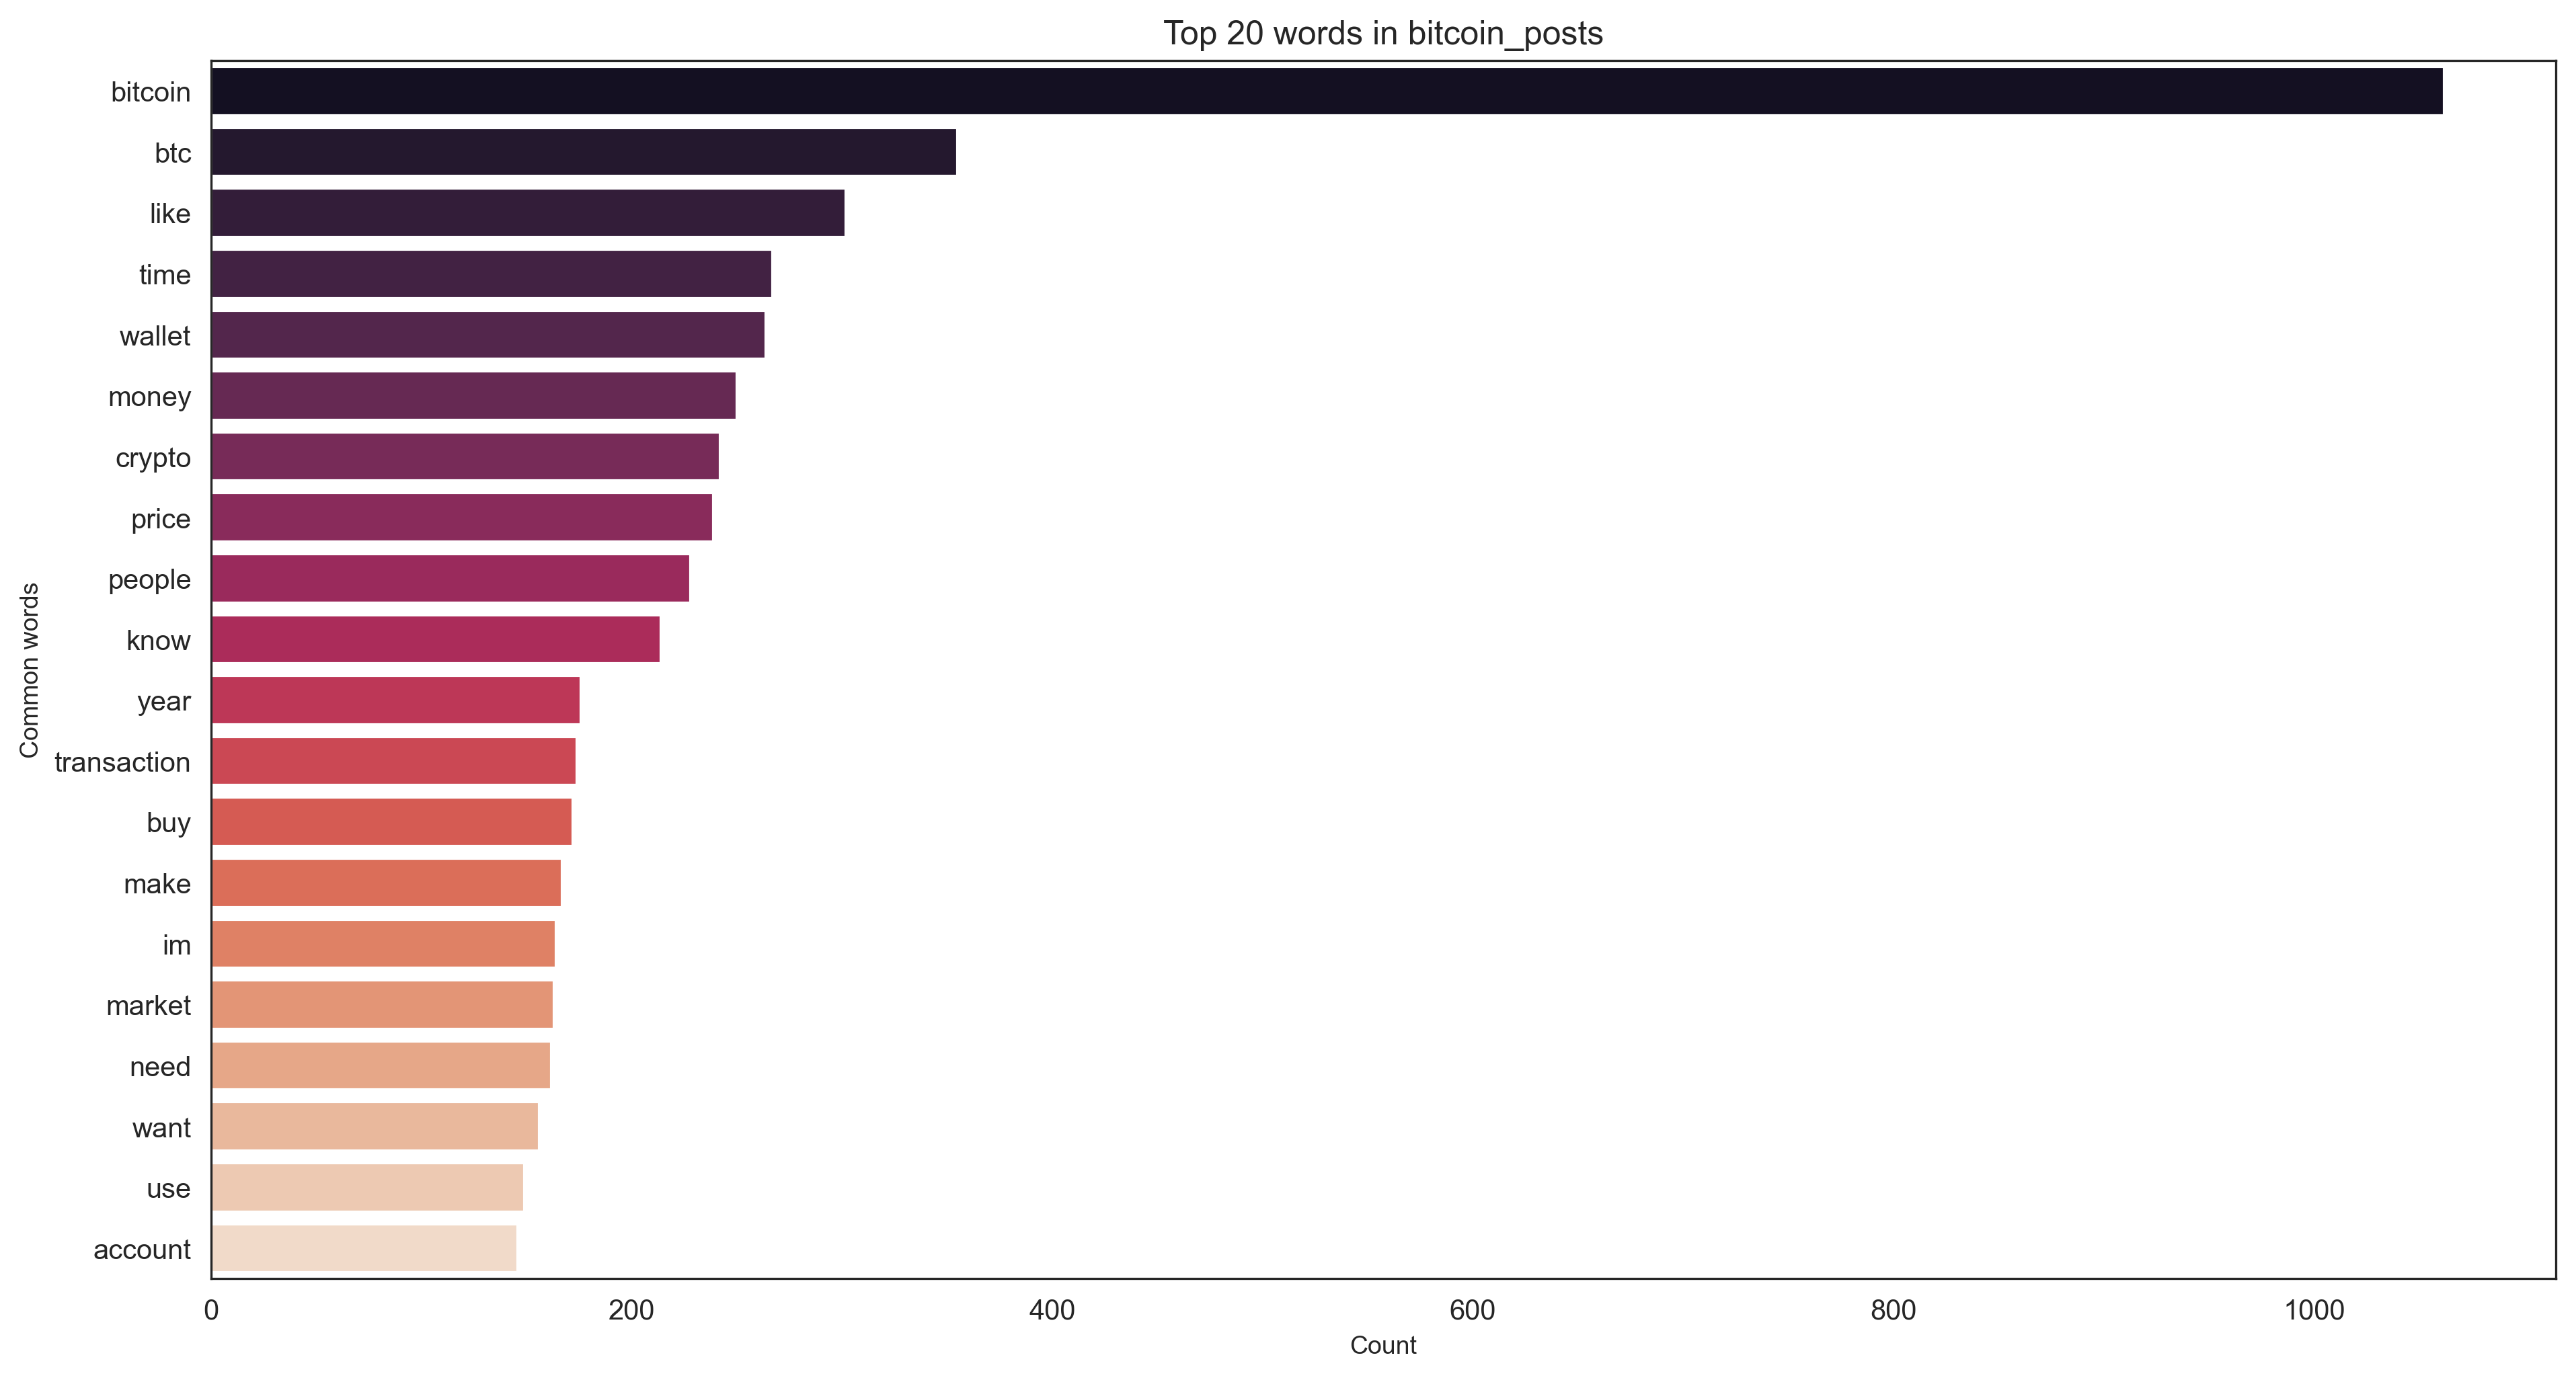

In [56]:
# Call function to plot top 20 words of bitcoin_posts
plot_top_20_words(bitcoin_posts, title = 'Top 20 words in bitcoin_posts', palette = 'rocket')

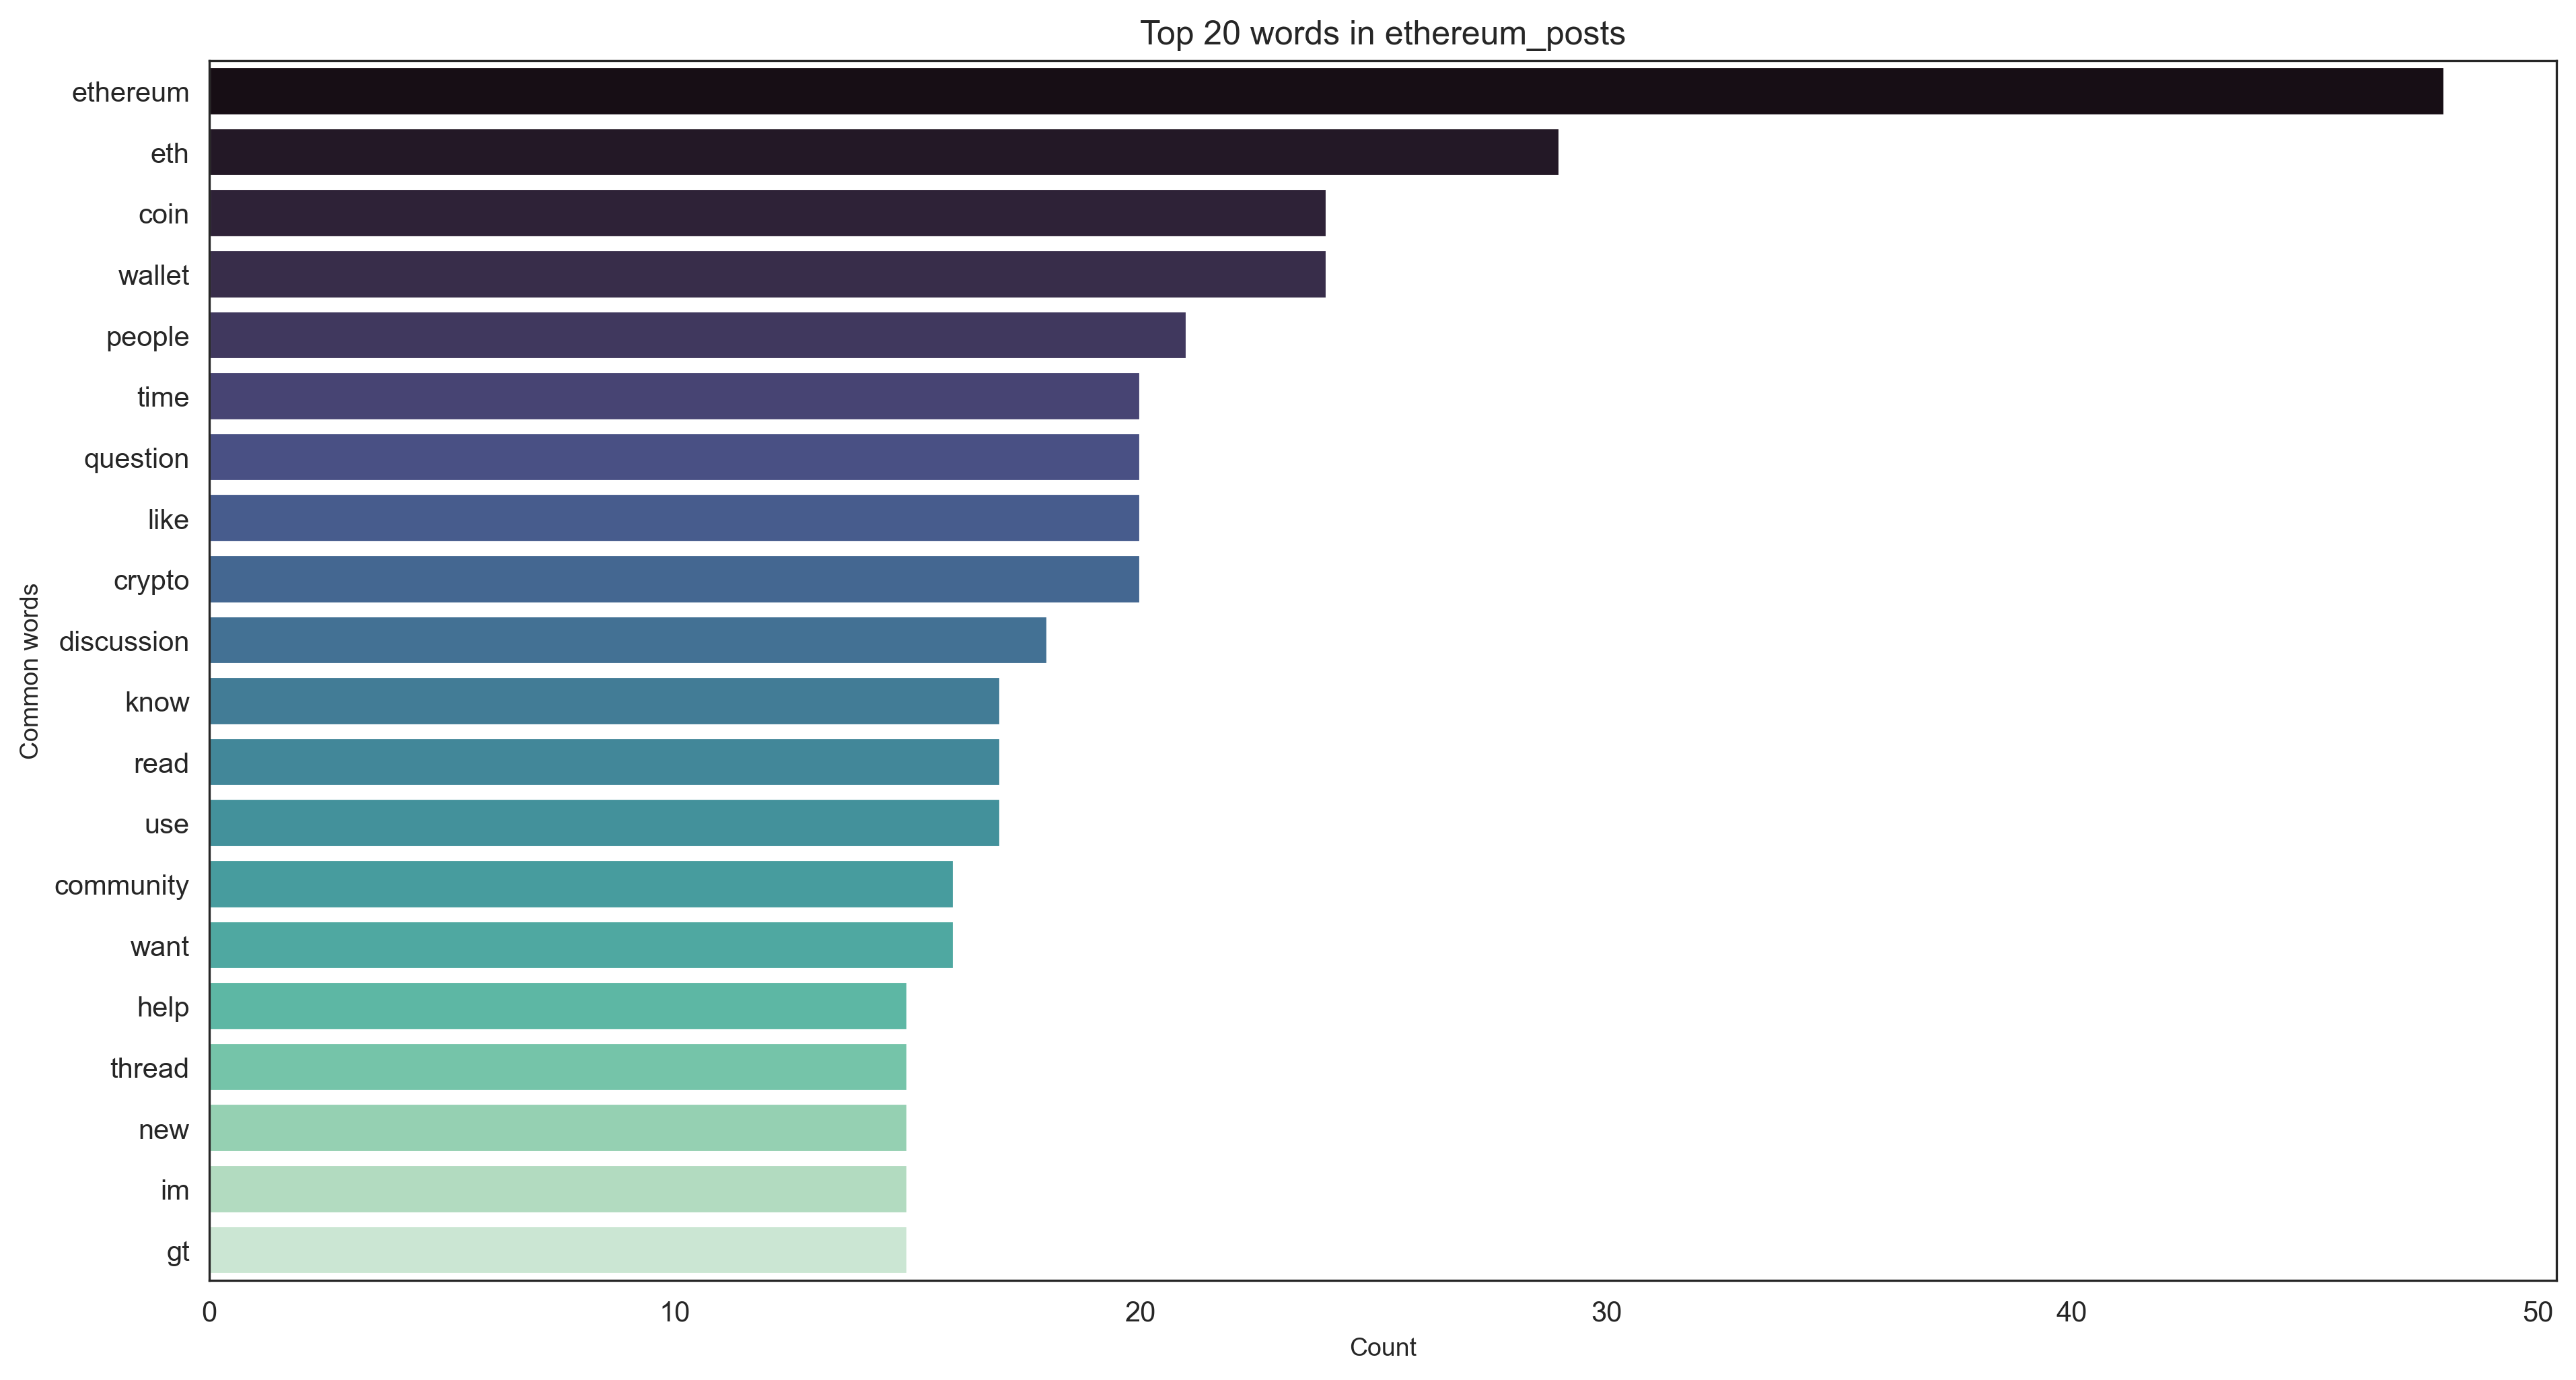

In [57]:
# Call function to plot top 20 words of ethereum_posts
plot_top_20_words(ethereum_posts, title = 'Top 20 words in ethereum_posts', palette = 'mako')

#### Review of top 20 words in the posts of both subreddits

Here we do not see as many similar words as there are in the titles of the two subreddits. One key difference in the posts of each subreddit is the use of name and coin symbol. In r/Bitcoin posts, the most used words are 'Bitcoin and 'btc'. On the other hand in r/Ethereum posts, the most used words are 'Ethereum' and 'eth'. We also see words like 'community' and 'thread' ranked in the top 20 of ethereum_posts but not in bitcoin_posts. Since 'selftext_length' is only less than three times as long as 'title_length', on average, it seemed like forming a new column to combine 'selftext_clean' and 'title_clean' would work better as text features.  

In [58]:
# Create a new column to combine the text in 'title_clean' and 'selftext_clean' columns
combined_data['more_text_clean'] = combined_data['title_clean'] + combined_data['selftext_clean']

In [59]:
# Check how new column looks like
combined_data.head()

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url,is_bitcoin,title_clean,selftext_clean,title_length,selftext_length,more_text_clean
0,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",emptypost,link,1,None,Bitcoin,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,1,"[crypto, influencers, dorsey, wood, musk, faceoff, bword, conference]",[emptypost],8,1,"[crypto, influencers, dorsey, wood, musk, faceoff, bword, conference, emptypost]"
1,Elon Musk’s View on Bitcoin (July 21 2021),emptypost,rich:video,2,None,Bitcoin,https://youtu.be/7pLusWKO86Y,1,"[elon, musk, view, bitcoin, july, 21, 2021]",[emptypost],7,1,"[elon, musk, view, bitcoin, july, 21, 2021, emptypost]"
2,best crypto video ive ever watched,emptypost,rich:video,2,None,Bitcoin,https://www.youtube.com/watch?v=WgyM0tQ0Hfs&amp;t=30s,1,"[best, crypto, video, ive, ever, watched]",[emptypost],6,1,"[best, crypto, video, ive, ever, watched, emptypost]"
3,what moves crypto market apart from the speculators,I would like to know if there is anything that moves crypto market apart from the speculator...,None,7,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8j7o/what_moves_crypto_market_apart_from_the/,1,"[move, crypto, market, apart, speculator]","[, would, like, know, anything, move, crypto, market, apart, speculator, cryptocurrencies, price...",5,14,"[move, crypto, market, apart, speculator, , would, like, know, anything, move, crypto, market, a..."
4,Help starting crypto business,Hi guys.\n\nI'm interested in starting a crypto business / app www.hashtaghodl.com that would ta...,None,5,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8cdl/help_starting_crypto_business/,1,"[help, starting, crypto, business]","[hi, guy, im, interested, starting, crypto, business, app, wwwhashtaghodlcom, would, take, small...",4,48,"[help, starting, crypto, business, hi, guy, im, interested, starting, crypto, business, app, www..."


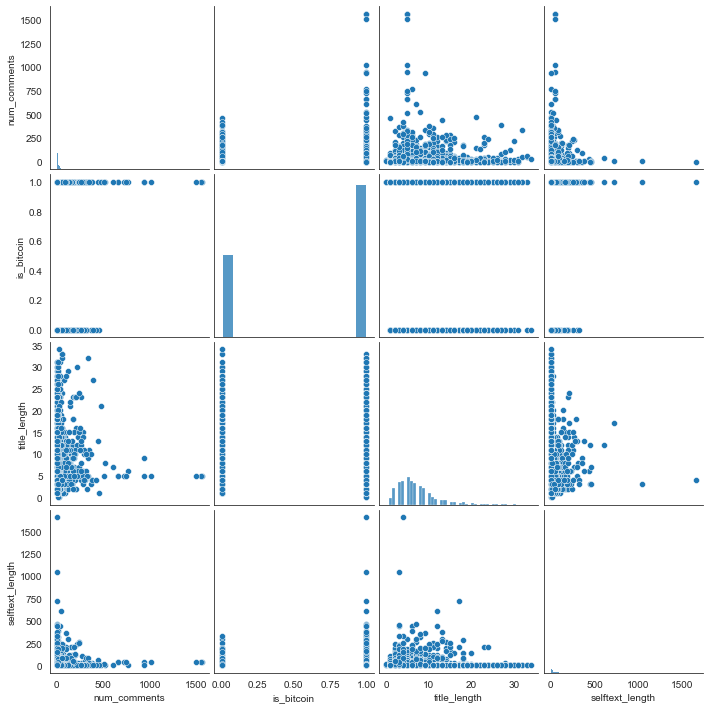

In [60]:
# Pairplot below shows that there is no linear correlation between any of the numeric variables in the data frame
sns.pairplot(combined_data);

In [61]:
# Remove more stopwords from 'more_text_clean' column
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'wallet'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'crypto'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'time'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'like'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'know'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'get'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != '2021'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'people'])
combined_data['more_text_clean'] = combined_data['more_text_clean'].apply(
                                   lambda row: [val for val in row if val != 'would'])

In [62]:
# Create a new column to remove 'emptypost' from 'more_text_clean' column
combined_data['final_text_clean'] = combined_data['more_text_clean'].apply(
                                    lambda row: [val for val in row if val != 'emptypost']
)

In [63]:
# Check that new column has been added
combined_data.head()

,title,selftext,post_hint,num_comments,removed_by_category,subreddit,url,is_bitcoin,title_clean,selftext_clean,title_length,selftext_length,more_text_clean,final_text_clean
0,"Crypto Influencers Dorsey, Woods, and Musk Face-off During B-Word Conference",emptypost,link,1,None,Bitcoin,https://dailycoin.com/crypto-influencers-dorsey-woods-and-musk-face-off-during-b-word-conference/,1,"[crypto, influencers, dorsey, wood, musk, faceoff, bword, conference]",[emptypost],8,1,"[influencers, dorsey, wood, musk, faceoff, bword, conference, emptypost]","[influencers, dorsey, wood, musk, faceoff, bword, conference]"
1,Elon Musk’s View on Bitcoin (July 21 2021),emptypost,rich:video,2,None,Bitcoin,https://youtu.be/7pLusWKO86Y,1,"[elon, musk, view, bitcoin, july, 21, 2021]",[emptypost],7,1,"[elon, musk, view, bitcoin, july, 21, emptypost]","[elon, musk, view, bitcoin, july, 21]"
2,best crypto video ive ever watched,emptypost,rich:video,2,None,Bitcoin,https://www.youtube.com/watch?v=WgyM0tQ0Hfs&amp;t=30s,1,"[best, crypto, video, ive, ever, watched]",[emptypost],6,1,"[best, video, ive, ever, watched, emptypost]","[best, video, ive, ever, watched]"
3,what moves crypto market apart from the speculators,I would like to know if there is anything that moves crypto market apart from the speculator...,None,7,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8j7o/what_moves_crypto_market_apart_from_the/,1,"[move, crypto, market, apart, speculator]","[, would, like, know, anything, move, crypto, market, apart, speculator, cryptocurrencies, price...",5,14,"[move, market, apart, speculator, , anything, move, market, apart, speculator, cryptocurrencies,...","[move, market, apart, speculator, , anything, move, market, apart, speculator, cryptocurrencies,..."
4,Help starting crypto business,Hi guys.\n\nI'm interested in starting a crypto business / app www.hashtaghodl.com that would ta...,None,5,None,Bitcoin,https://www.reddit.com/r/Bitcoin/comments/op8cdl/help_starting_crypto_business/,1,"[help, starting, crypto, business]","[hi, guy, im, interested, starting, crypto, business, app, wwwhashtaghodlcom, would, take, small...",4,48,"[help, starting, business, hi, guy, im, interested, starting, business, app, wwwhashtaghodlcom, ...","[help, starting, business, hi, guy, im, interested, starting, business, app, wwwhashtaghodlcom, ..."


In [64]:
# Finalize dataset by dropping columns that will not be used in modelling
combined_data.drop(['post_hint', 'num_comments','removed_by_category', 'url'],axis =1, inplace=True)

In [65]:
# One last check for missing value
combined_data.isnull().sum()

title               0
selftext            0
subreddit           0
is_bitcoin          0
title_clean         0
selftext_clean      0
title_length        0
selftext_length     0
more_text_clean     0
final_text_clean    0
dtype: int64

In [66]:
combined_data.shape

(2786, 10)

In [67]:
# Export final combined dataset to csv
combined_data.to_csv('/Users/Ash/Desktop/Project-3/data/final_dataset.csv', index=False)